<a href="https://colab.research.google.com/github/yuniton/NarutoAI/blob/master/Money.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd ../content/drive/My Drive/Colab Notebooks/Money

/content/drive/My Drive/Colab Notebooks/Money


In [0]:
# import numpy as np
# import cv2

# src = cv2.imread('お札(裏).png',0)
# for i in range(256):
#   img = src+i
#   cv2.imwrite("No. "+str(i)+" お札(裏) .png",img)

#輝度を0~255まで変動させ一枚ずつ出力

In [0]:
#ラベリングによる学習/検証データの準備

from PIL import Image
import os, glob
import numpy as np
import random, math

#画像が保存されているルートディレクトリのパス
root_dir = "Model"
# 商品名
categories = ["良品","不良品"]

# 画像データ用配列
X = []
# ラベルデータ用配列
Y = []

# imgg = Image.open("Model/良品/No. 1 お札(表) .png")  # イメージを開く
# print("元の画像サイズ　width: {}, height: {}".format(imgg.size[0], imgg.size[1]))  # 元の画像のサイズ出力

#画像データごとにadd_sample()を呼び出し、X,Yの配列を返す関数
def make_sample(files):
    global X, Y
    X = []
    Y = []
    for cat, fname in files:
        add_sample(cat, fname)
    return np.array(X), np.array(Y)

#渡された画像データを読み込んでXに格納し、また、
#画像データに対応するcategoriesのidxをY格納する関数
def add_sample(cat, fname):
    img = Image.open(fname)
    img = img.convert("RGB")
    img = img.resize((920, 460))
    data = np.asarray(img)
    X.append(data)
    Y.append(cat)

#全データ格納用配列
allfiles = []

#カテゴリ配列の各値と、それに対応するidxを認識し、全データをallfilesにまとめる
for idx, cat in enumerate(categories):
    image_dir = root_dir + "/" + cat
    files = glob.glob(image_dir + "/*.png")
    for f in files:
        allfiles.append((idx, f))

#シャッフル後、学習データと検証データに分ける
random.shuffle(allfiles)
th = math.floor(len(allfiles) * 0.8)
train = allfiles[0:th]
test  = allfiles[th:]
X_train, y_train = make_sample(train)
X_test, y_test = make_sample(test)
xy = (X_train, X_test, y_train, y_test)
#データを保存する（データの名前を「money_data.npy」としている）
np.save("money_data.npy", xy)

In [4]:
#モデルの構築

from keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(460,920,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))  #過学習を防ぐ
model.add(layers.Dense(512,activation="relu"))
model.add(layers.Dense(2,activation="sigmoid")) #分類先の種類分設定

#モデル構成の確認
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 458, 918, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 229, 459, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 227, 457, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 113, 228, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 111, 226, 128)     73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 113, 128)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 53, 111, 128)     

In [8]:
#モデルのコンパイル



from keras import optimizers

from money_model import model

model.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=["acc"])

#データの準備

from keras.utils import np_utils
import numpy as np

categories = ["良品","不良品"]
nb_classes = len(categories)

X_train, X_test, y_train, y_test = np.load("money_data.npy", allow_pickle=True)

#データの正規化
X_train = X_train.astype("float") / 255
X_test  = X_test.astype("float") / 255

#kerasで扱えるようにcategoriesをベクトルに変換
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test  = np_utils.to_categorical(y_test, nb_classes)


#モデルの学習
from preparation import X_train, y_train, X_test, y_test

model = model.fit(X_train,
                  y_train,
                  epochs=10,
                  batch_size=10,
                  validation_data=(X_test,y_test))

KeyboardInterrupt: ignored

In [0]:
# #データの準備

# from keras.utils import np_utils
# import numpy as np

# categories = ["良品","不良品"]
# nb_classes = len(categories)

# X_train, X_test, y_train, y_test = np.load("money_data.npy", allow_pickle=True)

# #データの正規化
# X_train = X_train.astype("float") / 255
# X_test  = X_test.astype("float") / 255

# #kerasで扱えるようにcategoriesをベクトルに変換
# y_train = np_utils.to_categorical(y_train, nb_classes)
# y_test  = np_utils.to_categorical(y_test, nb_classes)




KeyboardInterrupt: ignored

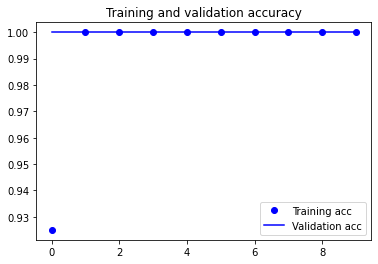

In [7]:
#学習結果を表示

import matplotlib.pyplot as plt

# from model_compile import model

acc = model.history['acc']
val_acc = model.history['val_acc']
loss = model.history['loss']
val_loss = model.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('model_accuracy_graph')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('model_loss_graph')

In [0]:
#モデルの保存
from model_compile import model

json_string = model.model.to_json()
open('money_modelResult.json', 'w').write(json_string)

#重みの保存

hdf5_file = "money_modelResult.hdf5"
model.model.save_weights(hdf5_file)

In [0]:
from PIL import Image
import os, glob
import numpy as np
import random, math
from tensorflow.python import confusion_matrix
from sklearn.metrics import accuracy_score



# 画像が保存されているディレクトリのパス


root_dir = "TEST"
# 画像が保存されているフォルダ名
categories = ["良品","不良品"]

X = [] # 画像データ
Y = [] # ラベルデータ

# フォルダごとに分けられたファイルを収集
#（categoriesのidxと、画像のファイルパスが紐づいたリストを生成）
allfiles = []
for idx, cat in enumerate(categories):
    image_dir = root_dir + "/" + cat
    files = glob.glob(image_dir + "/*.png")
    for f in files:
        allfiles.append((idx, f))

for cat, fname in allfiles:
    img = Image.open(fname)
    img = img.convert("RGB")
    img = img.resize((920, 460))
    data = np.asarray(img)
    X.append(data)
    Y.append(cat)

x = np.array(X)
y = np.array(Y)


np.save("money_data_test_X_150.npy", x)
np.save("money_data_test_Y_150.npy", y)


In [0]:
# モデルの精度を測る

#評価用のデータの読み込み
import numpy as np

from model_compile import model
from money_testData import x, y

eval_X = np.load("money_data_test_X_150.npy")
eval_Y = np.load("money_data_test_Y_150.npy")

#Yのデータをone-hotに変換
from keras.utils import np_utils

test_Y = np_utils.to_categorical(eval_Y,2)

score = model.model.evaluate(x=eval_X,y=test_Y)

print('loss=', score[0])
print('accuracy=', score[1])



In [0]:
#あなたの千円札を選ばせるプログラム

from keras import models
from keras.models import model_from_json
from keras.preprocessing import image
import numpy as np

#保存したモデルの読み込み
model = model_from_json(open('money_modelResult.json').read())
#保存した重みの読み込み
model.load_weights('money_modelResult.hdf5')

categories = ["良品","不良品"]



#画像を読み込む
img_path =str(input())
img = image.load_img(img_path,target_size=(460, 920, 3))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

#予測
features = model.predict(x)

#予測結果によって処理を分ける
if features[0,0] == 1:
    print ("これはあなたの千円札です")

else:
    for i in range(0,2):
        if features[0,i] == 1:
            cat = categories[i]
    message = "私の1000札ではないので、受け取れません"
    print(message)

